# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, roc_curve, auc, precision_score, roc_auc_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE


# Data Processing

In [3]:
train_df = pd.read_csv("../../data/train_data_v3.csv")
validate_df = pd.read_csv("../../data/validate_data_v3.csv")
test_df = pd.read_csv("../../data/test_data_v3.csv")

In [4]:
print(train_df.shape)
print(validate_df.shape)
print(test_df.shape)

(8000, 42)
(1000, 42)
(1000, 42)


In [5]:
train_df.head()

,ID,End_Time,Distance(mi),Description,Zipcode,Weather_Timestamp,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),...,City_Los Angeles,City_Miami,City_Orlando,City_Others,Weather_Condition_Encoded,Weather_Condition_Fog / Low Visibility,Weather_Condition_Others,Weather_Condition_Snow,Weather_Condition_Thunderstorms / Severe Weather,Severity
0,A-547872,372,0.0,Crash on Hard Scrabble Rd at Clemson Rd.,29223-8559,2022-08-03 05:53:00,77.0,88.0,29.81,10.0,...,0,0,0,1,0,0,0,0,0,1
1,A-6997925,922,0.0,At OH-87/S Woodland Rd - Accident.,44022,2020-06-03 14:45:00,75.0,65.0,28.84,20.0,...,0,0,0,1,0,0,0,0,0,1
2,A-539957,649,0.0,Crash on Rosewood Ave at Nansemond St.,23221-3430,2022-08-11 09:54:00,79.0,84.0,29.80,10.0,...,0,0,0,1,0,0,0,0,0,1
3,A-556754,544,0.0,Crash on Gellhorn Dr at Loop Fwy.,77029,2022-07-25 07:53:00,82.0,79.0,29.98,10.0,...,0,0,0,0,0,0,0,0,0,1
4,A-7040745,993,0.0,At CR-676A/Bloomingdale Av/Progress BL - Accid...,33578,2020-05-20 15:55:00,86.0,55.0,29.91,10.0,...,0,0,0,1,0,0,0,0,0,1


In [6]:
train_df.dtypes

ID                                                   object
End_Time                                              int64
Distance(mi)                                        float64
Description                                          object
Zipcode                                              object
Weather_Timestamp                                    object
Temperature(F)                                      float64
Humidity(%)                                         float64
Pressure(in)                                        float64
Visibility(mi)                                      float64
Wind_Direction                                       object
Wind_Speed(mph)                                     float64
Precipitation(in)                                   float64
Amenity                                               int64
Bump                                                  int64
Crossing                                              int64
Give_Way                                

In [7]:
for name, df in zip(['train_df', 'validate_df', 'test_df'], [train_df, validate_df, test_df]):
    print(f"Missing values in {name}:")
    print(df.isna().sum())
    print("\n")


Missing values in train_df:
ID                                                  0
End_Time                                            0
Distance(mi)                                        0
Description                                         0
Zipcode                                             0
Weather_Timestamp                                   0
Temperature(F)                                      0
Humidity(%)                                         0
Pressure(in)                                        0
Visibility(mi)                                      0
Wind_Direction                                      0
Wind_Speed(mph)                                     0
Precipitation(in)                                   0
Amenity                                             0
Bump                                                0
Crossing                                            0
Give_Way                                            0
Junction                                            0


### Process datetime column

In [8]:
def encode_timestamp(df):
    df['Weather_Timestamp'] = pd.to_datetime(df['Weather_Timestamp'], errors='coerce')

    # Extract features
    df['Weather_Year'] = df['Weather_Timestamp'].dt.year
    df['Weather_Month'] = df['Weather_Timestamp'].dt.month
    df['Weather_Day'] = df['Weather_Timestamp'].dt.day
    df['Weather_Hour'] = df['Weather_Timestamp'].dt.hour
    df['Weather_Day_of_Week'] = df['Weather_Timestamp'].dt.dayofweek  # 0 = Monday, 6 = Sunday
    df['Weather_Is_Weekend'] = df['Weather_Day_of_Week'].isin([5, 6]).astype(int)

    df.drop(columns=['Weather_Timestamp'], inplace=True)
    return df

In [9]:
train_df = encode_timestamp(train_df)
print(f"train_df shape: {train_df.shape}")
train_df.head()

train_df shape: (8000, 47)


,ID,End_Time,Distance(mi),Description,Zipcode,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,...,Weather_Condition_Others,Weather_Condition_Snow,Weather_Condition_Thunderstorms / Severe Weather,Severity,Weather_Year,Weather_Month,Weather_Day,Weather_Hour,Weather_Day_of_Week,Weather_Is_Weekend
0,A-547872,372,0.0,Crash on Hard Scrabble Rd at Clemson Rd.,29223-8559,77.0,88.0,29.81,10.0,CALM,...,0,0,0,1,2022,8,3,5,2,0
1,A-6997925,922,0.0,At OH-87/S Woodland Rd - Accident.,44022,75.0,65.0,28.84,20.0,W,...,0,0,0,1,2020,6,3,14,2,0
2,A-539957,649,0.0,Crash on Rosewood Ave at Nansemond St.,23221-3430,79.0,84.0,29.80,10.0,VAR,...,0,0,0,1,2022,8,11,9,3,0
3,A-556754,544,0.0,Crash on Gellhorn Dr at Loop Fwy.,77029,82.0,79.0,29.98,10.0,CALM,...,0,0,0,1,2022,7,25,7,0,0
4,A-7040745,993,0.0,At CR-676A/Bloomingdale Av/Progress BL - Accid...,33578,86.0,55.0,29.91,10.0,SW,...,0,0,0,1,2020,5,20,15,2,0


In [10]:
validate_df = encode_timestamp(validate_df)
print(f"validate_df shape: {validate_df.shape}")
validate_df.head()

validate_df shape: (1000, 47)


,ID,End_Time,Distance(mi),Description,Zipcode,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,...,Weather_Condition_Others,Weather_Condition_Snow,Weather_Condition_Thunderstorms / Severe Weather,Severity,Weather_Year,Weather_Month,Weather_Day,Weather_Hour,Weather_Day_of_Week,Weather_Is_Weekend
0,A-6440727,1376,0.013,Incident on E HOLT BLVD near CORONA AVE Drive ...,91761-2110,46.0,83.0,29.02,10.0,CALM,...,0,0,0,2,2021,1,29,20,4,0
1,A-3749509,1152,0.086,Incident on BISCAYNE BAY DR near HOUSE 12700 D...,33181,79.0,62.0,30.05,10.0,NE,...,0,0,0,2,2022,12,5,16,0,0
2,A-7118981,928,0.700,At MD-5/Branch Ave/Exit 7 - Accident.,20748,60.0,55.0,29.80,10.0,W,...,0,0,0,3,2020,3,17,14,1,0
3,A-2308799,327,0.000,Accident on I-94 Westbound at Exit 208 Schaefe...,48120,18.0,84.0,31.08,1.2,East,...,0,1,0,3,2019,2,27,4,2,0
4,A-5403565,656,0.386,Crash blocking the left lane on SR-260 Westbou...,85541,72.0,69.0,25.02,10.0,CALM,...,0,0,0,2,2022,7,30,9,5,1


In [11]:
test_df = encode_timestamp(test_df)
print(f"test_df shape: {test_df.shape}")
test_df.head()

test_df shape: (1000, 47)


,ID,End_Time,Distance(mi),Description,Zipcode,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,...,Weather_Condition_Others,Weather_Condition_Snow,Weather_Condition_Thunderstorms / Severe Weather,Severity,Weather_Year,Weather_Month,Weather_Day,Weather_Hour,Weather_Day_of_Week,Weather_Is_Weekend
0,A-924015,484,0.000,Lane blocked due to accident on OR-238 Westbou...,97530,54.0,66.0,28.71,8.0,CALM,...,0,0,0,2,2021,8,26,6,3,0
1,A-1744687,556,0.000,Accident on CR-266 John St both ways at Perkin...,14623-2417,40.0,93.0,29.73,7.0,CALM,...,0,0,0,2,2019,10,10,7,3,0
2,A-5488029,1109,0.711,Slow traffic on I-20 W from SC-215/Monticello ...,29210,82.0,69.0,29.62,10.0,SW,...,0,0,0,2,2021,6,22,17,1,0
3,A-3844411,974,0.141,NYSDOT - Region 8: Crash on Taconic State Park...,12037,32.0,96.0,28.60,3.0,CALM,...,0,1,0,2,2023,1,19,14,3,0
4,A-1353192,616,0.000,Accident on Illinois Ave at 48th Ave.,37209-3441,68.0,81.0,29.56,10.0,E,...,0,0,0,2,2020,10,22,8,3,0


### Process categorical columns

In [12]:
for name, df in zip(['train_df', 'validate_df', 'test_df'], [train_df, validate_df, test_df]):
    print(f"--- {name} ---")
    for col in ['Wind_Direction', 'Description', 'Zipcode']:
        unique_values = df[col].unique()
        value_counts = df[col].value_counts()

        print(f"\nColumn: {col}")
        print(f"Unique values ({len(unique_values)}): {unique_values}")
        print("Value counts:")
        print(value_counts)
        print("-" * 40)
    print("\n" + "=" * 60 + "\n")



--- train_df ---

Column: Wind_Direction
Unique values (23): ['CALM' 'W' 'VAR' 'SW' 'SE' 'S' 'WSW' 'E' 'NE' 'N' 'NNW' 'SSW' 'NNE' 'NW'
 'ESE' 'ENE' 'SSE' 'WNW' 'North' 'West' 'South' 'Variable' 'East']
Value counts:
Wind_Direction
CALM        1301
S            641
W            553
SSW          457
N            427
SW           420
WNW          416
SSE          383
WSW          382
VAR          378
NW           372
E            363
NNW          334
SE           326
NNE          294
ESE          274
ENE          273
NE           245
East          43
South         39
North         37
West          26
Variable      16
Name: count, dtype: int64
----------------------------------------

Column: Description
Unique values (7823): ['Crash on Hard Scrabble Rd at Clemson Rd.'
 'At OH-87/S Woodland Rd - Accident.'
 'Crash on Rosewood Ave at Nansemond St.' ...
 'At Pleasant Hill Rd - Accident.'
 'Closed at US-220-BR/VA-457/Memorial Blvd - Road closed due to accident.'
 'Closed between CR-19/S Cente

In [13]:
def encode_categorical(df, reference_columns=None):
    # One-hot encode 'Wind_Direction'
    df = pd.get_dummies(df, columns=['Wind_Direction'], drop_first=True)

    # Convert True/False to 0/1 after encoding
    for col in df.select_dtypes(include=['bool']).columns:
        df[col] = df[col].astype(int)

    # Ensure consistent columns for validate/test DataFrame
    if reference_columns is not None:
        missing_cols = [col for col in reference_columns if col not in df.columns]
        for col in missing_cols:
            df[col] = 0  # Add missing columns with 0s
        df = df[reference_columns]

    return df

In [14]:
train_df = encode_categorical(train_df)
print(f"train_df shape: {train_df.shape}")
train_df.head()

train_df shape: (8000, 68)


,ID,End_Time,Distance(mi),Description,Zipcode,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),...,Wind_Direction_SSE,Wind_Direction_SSW,Wind_Direction_SW,Wind_Direction_South,Wind_Direction_VAR,Wind_Direction_Variable,Wind_Direction_W,Wind_Direction_WNW,Wind_Direction_WSW,Wind_Direction_West
0,A-547872,372,0.0,Crash on Hard Scrabble Rd at Clemson Rd.,29223-8559,77.0,88.0,29.81,10.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,A-6997925,922,0.0,At OH-87/S Woodland Rd - Accident.,44022,75.0,65.0,28.84,20.0,17.0,...,0,0,0,0,0,0,1,0,0,0
2,A-539957,649,0.0,Crash on Rosewood Ave at Nansemond St.,23221-3430,79.0,84.0,29.80,10.0,3.0,...,0,0,0,0,1,0,0,0,0,0
3,A-556754,544,0.0,Crash on Gellhorn Dr at Loop Fwy.,77029,82.0,79.0,29.98,10.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,A-7040745,993,0.0,At CR-676A/Bloomingdale Av/Progress BL - Accid...,33578,86.0,55.0,29.91,10.0,7.0,...,0,0,1,0,0,0,0,0,0,0


In [15]:
validate_df = encode_categorical(validate_df, reference_columns=train_df.columns)
print(f"validate_df shape: {validate_df.shape}")
validate_df.head()

validate_df shape: (1000, 68)


,ID,End_Time,Distance(mi),Description,Zipcode,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),...,Wind_Direction_SSE,Wind_Direction_SSW,Wind_Direction_SW,Wind_Direction_South,Wind_Direction_VAR,Wind_Direction_Variable,Wind_Direction_W,Wind_Direction_WNW,Wind_Direction_WSW,Wind_Direction_West
0,A-6440727,1376,0.013,Incident on E HOLT BLVD near CORONA AVE Drive ...,91761-2110,46.0,83.0,29.02,10.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,A-3749509,1152,0.086,Incident on BISCAYNE BAY DR near HOUSE 12700 D...,33181,79.0,62.0,30.05,10.0,9.0,...,0,0,0,0,0,0,0,0,0,0
2,A-7118981,928,0.700,At MD-5/Branch Ave/Exit 7 - Accident.,20748,60.0,55.0,29.80,10.0,13.0,...,0,0,0,0,0,0,1,0,0,0
3,A-2308799,327,0.000,Accident on I-94 Westbound at Exit 208 Schaefe...,48120,18.0,84.0,31.08,1.2,10.4,...,0,0,0,0,0,0,0,0,0,0
4,A-5403565,656,0.386,Crash blocking the left lane on SR-260 Westbou...,85541,72.0,69.0,25.02,10.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
test_df = encode_categorical(test_df, reference_columns=train_df.columns)
print(f"test_df shape: {test_df.shape}")
test_df.head()

test_df shape: (1000, 68)


,ID,End_Time,Distance(mi),Description,Zipcode,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),...,Wind_Direction_SSE,Wind_Direction_SSW,Wind_Direction_SW,Wind_Direction_South,Wind_Direction_VAR,Wind_Direction_Variable,Wind_Direction_W,Wind_Direction_WNW,Wind_Direction_WSW,Wind_Direction_West
0,A-924015,484,0.000,Lane blocked due to accident on OR-238 Westbou...,97530,54.0,66.0,28.71,8.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,A-1744687,556,0.000,Accident on CR-266 John St both ways at Perkin...,14623-2417,40.0,93.0,29.73,7.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,A-5488029,1109,0.711,Slow traffic on I-20 W from SC-215/Monticello ...,29210,82.0,69.0,29.62,10.0,9.0,...,0,0,1,0,0,0,0,0,0,0
3,A-3844411,974,0.141,NYSDOT - Region 8: Crash on Taconic State Park...,12037,32.0,96.0,28.60,3.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,A-1353192,616,0.000,Accident on Illinois Ave at 48th Ave.,37209-3441,68.0,81.0,29.56,10.0,3.0,...,0,0,0,0,0,0,0,0,0,0


### Drop irrelevant columns

In [17]:
irrelevant_columns = ["ID", "Description", "Zipcode"]
train_df = train_df.drop(columns=irrelevant_columns, errors='ignore')
validate_df = validate_df.drop(columns=irrelevant_columns, errors='ignore')
test_df = test_df.drop(columns=irrelevant_columns, errors='ignore')

# Evaluation Function

In [18]:
def evaluate(y_pred, y_test, X_test, model):
    # Evaluate the model
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Compute and display confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", conf_matrix)

    # Compute AUC-ROC curve
    y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4])
    y_pred_prob = model.predict_proba(X_test)
    n_classes = y_test_bin.shape[1]

    plt.figure()
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        plt.plot(fpr, tpr, label=f'Class {i+1} (AUC = {auc(fpr, tpr):.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-Class ROC Curve')
    plt.legend(loc='best')
    plt.show()

# Define Features & Target

In [19]:
# Define features and target
X_train = train_df.drop(columns=["Severity"])
y_train = train_df["Severity"]

X_validate = validate_df.drop(columns=["Severity"])
y_validate = validate_df["Severity"]

X_test = test_df.drop(columns=["Severity"])
y_test = test_df["Severity"]


# Baseline Model

In [20]:
y_train_adjusted = y_train - np.min(y_train)

# Train the Random Forest model
model = XGBClassifier(random_state=42, eval_metric='mlogloss')
model.fit(X_train, y_train_adjusted)

# Make predictions
y_pred = model.predict(X_validate)
y_pred_original = y_pred + np.min(y_train)


In [21]:
y_pred_original

array([2, 2, 4, 3, 2, 2, 2, 4, 2, 4, 1, 2, 2, 4, 4, 1, 2, 2, 2, 2, 2, 3,
       2, 2, 2, 4, 4, 2, 4, 1, 3, 2, 2, 4, 4, 2, 2, 2, 3, 2, 4, 3, 1, 1,
       4, 3, 4, 2, 2, 4, 4, 2, 2, 2, 2, 2, 3, 1, 2, 2, 3, 4, 3, 1, 2, 2,
       2, 3, 2, 2, 4, 2, 2, 3, 2, 2, 2, 2, 2, 1, 2, 3, 3, 2, 2, 2, 2, 3,
       2, 2, 2, 2, 2, 3, 3, 2, 1, 2, 4, 2, 2, 4, 2, 1, 3, 4, 1, 2, 2, 3,
       2, 3, 3, 2, 1, 1, 3, 1, 2, 2, 3, 2, 4, 2, 4, 3, 2, 2, 4, 2, 3, 3,
       1, 3, 2, 1, 4, 2, 2, 3, 4, 3, 4, 3, 4, 2, 2, 4, 2, 1, 3, 2, 2, 4,
       2, 2, 2, 3, 4, 2, 4, 1, 4, 4, 3, 4, 4, 4, 2, 4, 3, 4, 3, 4, 4, 4,
       2, 1, 2, 1, 3, 2, 4, 2, 2, 2, 3, 2, 3, 4, 2, 2, 2, 2, 2, 3, 4, 2,
       3, 4, 4, 2, 2, 2, 4, 4, 2, 4, 4, 2, 4, 3, 2, 1, 4, 1, 2, 3, 2, 2,
       3, 1, 2, 2, 2, 1, 4, 2, 2, 2, 2, 3, 3, 4, 3, 2, 4, 2, 4, 3, 2, 2,
       2, 2, 3, 4, 2, 4, 3, 2, 4, 3, 4, 3, 2, 3, 2, 2, 2, 1, 4, 4, 3, 2,
       2, 2, 2, 4, 3, 3, 3, 2, 2, 3, 3, 4, 1, 3, 2, 1, 3, 2, 3, 4, 4, 3,
       4, 2, 4, 2, 4, 3, 2, 3, 2, 3, 4, 4, 2, 3, 2,

Accuracy: 0.566
F1 Score: 0.6369755810505284
Classification Report:
               precision    recall  f1-score   support

           1       0.23      1.00      0.37        14
           2       0.97      0.52      0.68       828
           3       0.37      0.75      0.50       124
           4       0.10      0.74      0.18        34

    accuracy                           0.57      1000
   macro avg       0.42      0.75      0.43      1000
weighted avg       0.86      0.57      0.64      1000

Confusion Matrix:
 [[ 14   0   0   0]
 [ 35 434 154 205]
 [ 12   8  93  11]
 [  1   4   4  25]]


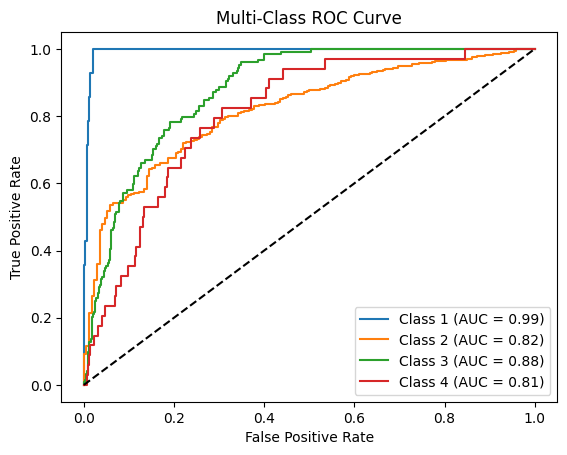

In [22]:
evaluate(y_pred_original, y_validate, X_validate, model)


Accuracy: 0.579
F1 Score: 0.6667205733060272
Classification Report:
               precision    recall  f1-score   support

           1       0.12      1.00      0.21         6
           2       0.97      0.56      0.71       857
           3       0.36      0.71      0.47       119
           4       0.05      0.61      0.09        18

    accuracy                           0.58      1000
   macro avg       0.37      0.72      0.37      1000
weighted avg       0.88      0.58      0.67      1000

Confusion Matrix:
 [[  6   0   0   0]
 [ 34 478 149 196]
 [ 10  10  84  15]
 [  1   4   2  11]]


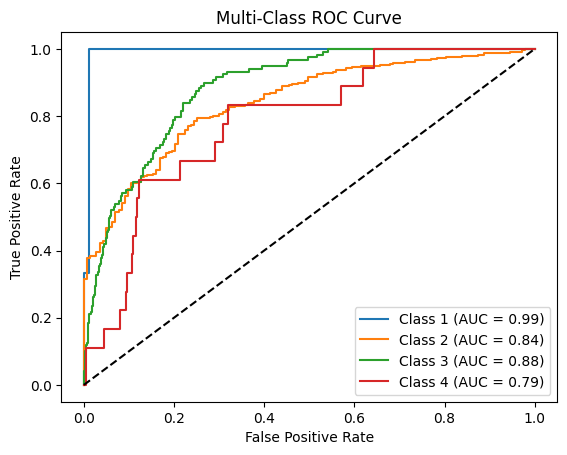

In [23]:
y_pred = model.predict(X_test)
y_pred_original = y_pred + np.min(y_train)

evaluate(y_pred_original, y_test, X_test, model)


# Backward Selection

Accuracy: 0.573
F1 Score: 0.6429747706388822
Classification Report:
               precision    recall  f1-score   support

           1       0.22      1.00      0.36        14
           2       0.97      0.54      0.69       828
           3       0.36      0.71      0.48       124
           4       0.11      0.76      0.19        34

    accuracy                           0.57      1000
   macro avg       0.41      0.75      0.43      1000
weighted avg       0.85      0.57      0.64      1000

Confusion Matrix:
 [[ 14   0   0   0]
 [ 39 445 150 194]
 [ 10  13  88  13]
 [  1   3   4  26]]


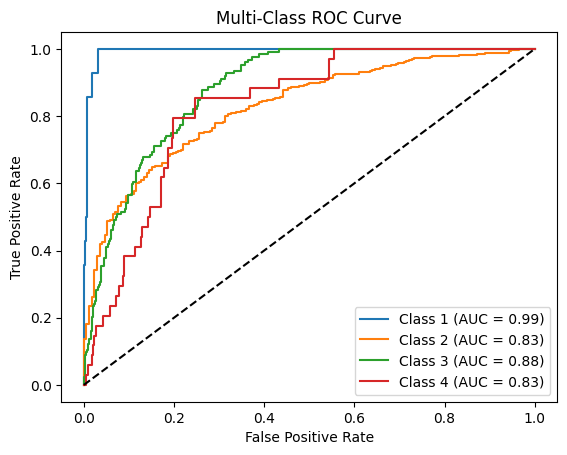

Accuracy: 0.587
F1 Score: 0.6750937371548971
Classification Report:
               precision    recall  f1-score   support

           1       0.12      1.00      0.21         6
           2       0.97      0.57      0.72       857
           3       0.38      0.72      0.49       119
           4       0.04      0.56      0.08        18

    accuracy                           0.59      1000
   macro avg       0.38      0.71      0.38      1000
weighted avg       0.88      0.59      0.68      1000

Confusion Matrix:
 [[  6   0   0   0]
 [ 33 485 140 199]
 [ 10   9  86  14]
 [  1   4   3  10]]


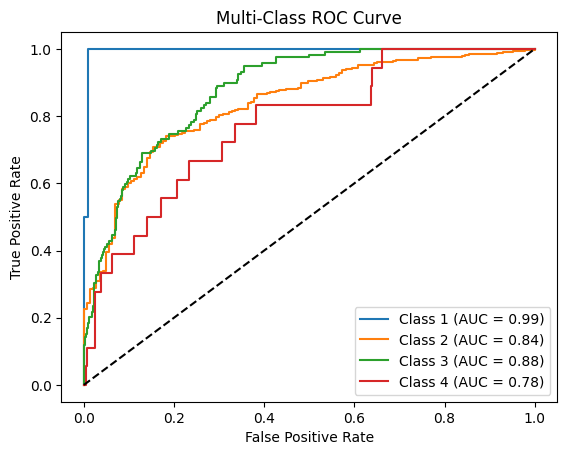

In [24]:
# Adjust target values if needed
y_train_adjusted = y_train - np.min(y_train)

# Initialize XGBoost model
model = XGBClassifier(random_state=42, eval_metric='mlogloss')

# Perform Recursive Feature Elimination (RFE) with backward selection
selector = RFE(model, step=1)  # step=1 removes the least important feature at a time
selector.fit(X_train, y_train_adjusted)

# Get selected feature names
selected_features = X_train.columns[selector.support_]

# Transform both training and validation datasets
X_train_selected = selector.transform(X_train)
X_validate_selected = selector.transform(X_validate)
X_test_selected = selector.transform(X_test)  # Apply to test set as well

# Train the final model on the selected features
model.fit(X_train_selected, y_train_adjusted)

# Make predictions
y_pred = model.predict(X_validate_selected)
y_pred_original = y_pred + np.min(y_train)

# Evaluate model performance
evaluate(y_pred_original, y_validate, X_validate_selected, model)

# Predict and evaluate on test set
y_pred_test = model.predict(X_test_selected)
y_pred_test_original = y_pred_test + np.min(y_train)
evaluate(y_pred_test_original, y_test, X_test_selected, model)




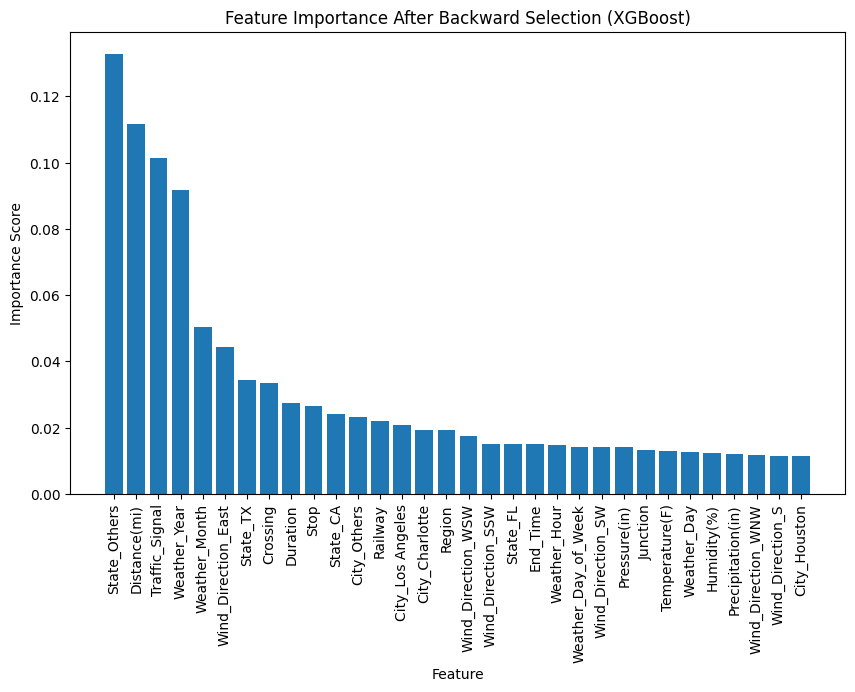

In [25]:
# Plot feature importance
feature_importance = model.feature_importances_
indices = np.argsort(feature_importance)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importance After Backward Selection (XGBoost)")
plt.bar(range(len(selected_features)), feature_importance[indices], align="center")
plt.xticks(range(len(selected_features)), np.array(selected_features)[indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.show()

# Parameter Tuning

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.8; total time

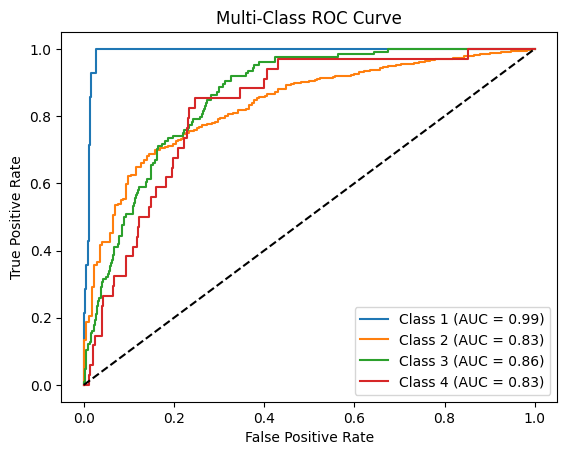

In [26]:
# Perform Recursive Feature Elimination (RFE)
selector = RFE(XGBClassifier(random_state=42, eval_metric="mlogloss"), step=1)
y_train_adjusted = y_train - np.min(y_train)

selector.fit(X_train, y_train_adjusted)

# Select only important features
X_train_selected = selector.transform(X_train)
X_validate_selected = selector.transform(X_validate)
X_test_selected = selector.transform(X_test)


# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 150],        # Number of trees in the model
    'max_depth': [3, 5, 10, 20],           # Maximum depth of each tree
    'learning_rate': [0.01, 0.1, 0.2],    # Step size for gradient descent
    'subsample': [0.8, 1.0],               # Proportion of samples used for training each tree
    'colsample_bytree': [0.8, 1.0],        # Proportion of features to be used for each tree
    'min_child_weight': [1, 2, 3],          # Minimum sum of instance weight (hessian) needed in a child
}



# Initialize RandomForestClassifier
xgb = XGBClassifier(random_state=42, eval_metric='mlogloss')

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the training data
grid_search.fit(X_train_selected, y_train_adjusted)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Print the best parameters found
print("Best parameters found: ", grid_search.best_params_)

# Make predictions using the best model on the validation set
y_pred_validate = best_model.predict(X_validate_selected)
y_pred_validate_original = y_pred_validate + np.min(y_train)

# Evaluate
print("\nEvaluate (Validation Set):")
evaluate(y_pred_validate_original, y_validate, X_validate_selected, best_model)



Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 20, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=8, min_child_weight=4, n_estimators=80, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=8, min_child_weight=4, n_estimators=80, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=8, min_child_weight=4, n_estimators=80, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=8, min_child_weight=4, n_estimators=80, subsample=0.9; total time=   1.6s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=8, min_child_weight=4, n_estimators=80, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=8, min_child_weight=4, n_estimators=80, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=8, min_child_weight=4, n_estimators=80, subsample=0.9; total time= 

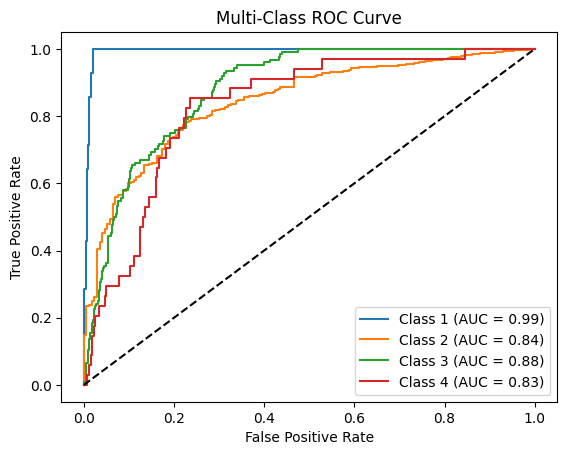

In [28]:
# Perform Recursive Feature Elimination (RFE)
selector = RFE(XGBClassifier(random_state=42, eval_metric="mlogloss"), step=1)
y_train_adjusted = y_train - np.min(y_train)

selector.fit(X_train, y_train_adjusted)

# Select only important features
X_train_selected = selector.transform(X_train)
X_validate_selected = selector.transform(X_validate)
X_test_selected = selector.transform(X_test)


# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [80, 120],        # Number of trees in the model
    'max_depth': [8, 12],           # Maximum depth of each tree
    'learning_rate': [0.05, 0.15],    # Step size for gradient descent
    'subsample': [0.7, 0.9],               # Proportion of samples used for training each tree
    'colsample_bytree': [0.7, 0.9],        # Proportion of features to be used for each tree
    'min_child_weight': [4, 5],          # Minimum sum of instance weight (hessian) needed in a child
}



# Initialize RandomForestClassifier
xgb = XGBClassifier(random_state=42, eval_metric='mlogloss')

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the training data
grid_search.fit(X_train_selected, y_train_adjusted)

# Get the best model from the grid search
best_model_second = grid_search.best_estimator_

# Print the best parameters found
print("Best parameters found: ", grid_search.best_params_)

# Make predictions using the best model on the validation set
y_pred_validate = best_model_second.predict(X_validate_selected)
y_pred_validate_original = y_pred_validate + np.min(y_train)

# Evaluate
print("\nEvaluate (Validation Set):")
evaluate(y_pred_validate_original, y_validate, X_validate_selected, best_model_second)



{'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 12, 'min_child_weight': 4, 'n_estimators': 120, 'subsample': 0.9}


Evaluate (Test Set):
Accuracy: 0.555
F1 Score: 0.6454591520598971
Classification Report:
               precision    recall  f1-score   support

           1       0.11      1.00      0.19         6
           2       0.98      0.53      0.68       857
           3       0.36      0.72      0.48       119
           4       0.05      0.72      0.10        18

    accuracy                           0.56      1000
   macro avg       0.37      0.74      0.36      1000
weighted avg       0.88      0.56      0.65      1000

Confusion Matrix:
 [[  6   0   0   0]
 [ 36 450 153 218]
 [ 13   8  86  12]
 [  1   2   2  13]]


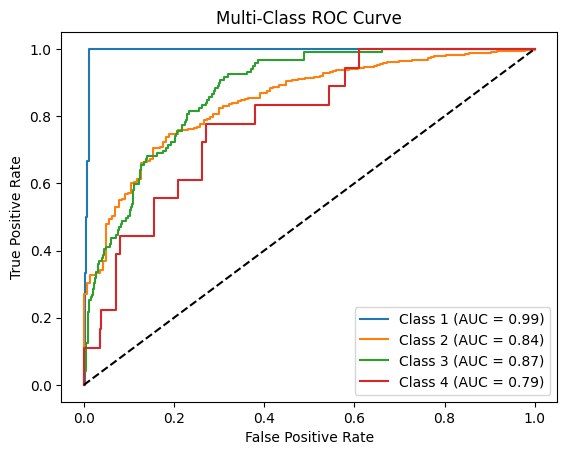

In [27]:
# Predict on the test set using the best model
y_pred_test = best_model.predict(X_test_selected)
y_pred_test_original = y_pred_test + np.min(y_train)

# Evaluate
print("\nEvaluate (Test Set):")
evaluate(y_pred_test_original, y_test, X_test_selected, best_model)


Evaluate (Test Set):
Accuracy: 0.563
F1 Score: 0.6527690333714949
Classification Report:
               precision    recall  f1-score   support

           1       0.11      1.00      0.19         6
           2       0.97      0.54      0.69       857
           3       0.35      0.69      0.47       119
           4       0.05      0.67      0.10        18

    accuracy                           0.56      1000
   macro avg       0.37      0.72      0.36      1000
weighted avg       0.87      0.56      0.65      1000

Confusion Matrix:
 [[  6   0   0   0]
 [ 37 463 149 208]
 [ 12  12  82  13]
 [  1   3   2  12]]


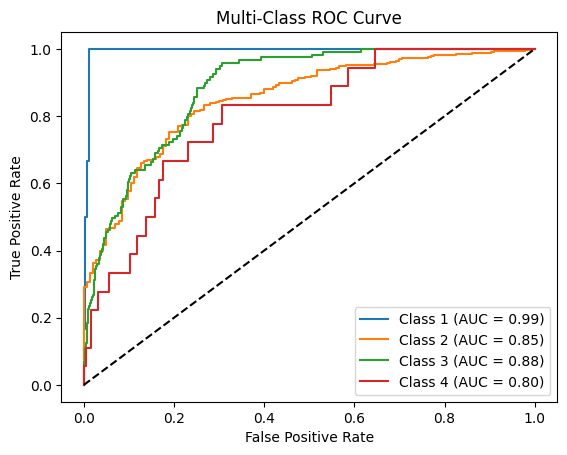

In [29]:
# Predict on the test set using the best model
y_pred_test = best_model_second.predict(X_test_selected)
y_pred_test_original = y_pred_test + np.min(y_train)

# Evaluate
print("\nEvaluate (Test Set):")
evaluate(y_pred_test_original, y_test, X_test_selected, best_model_second)